<a href="https://colab.research.google.com/github/MohamedKhalidmk/DeepLearning/blob/main/RNN_LSTM_Twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pandas scikit-learn

  Using cached pandas-2.2.3-cp310-cp310-win_amd64.whl.metadata (19 kB)
  Using cached scikit_learn-1.6.1-cp310-cp310-win_amd64.whl.metadata (15 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached scipy-1.15.3-cp310-cp310-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.5.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached pandas-2.2.3-cp310-cp310-win_amd64.whl (11.6 MB)
Using cached scikit_learn-1.6.1-cp310-cp310-win_amd64.whl (11.1 MB)
Using cached joblib-1.5.1-py3-none-any.whl (307 kB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached scipy-1.15.3-cp310-cp310-win_amd64.whl (41.3 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)

   ---------------------------------------- 0/7 [pytz]
   ---------------------------------------- 0/

In [ ]:
print("TensorFlow version:", tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs detected: {[gpu.name for gpu in gpus]}")
else:
    print("No GPU detected.")

TensorFlow version: 2.10.0
GPUs detected: ['/physical_device:GPU:0']


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
import re
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM
import time

In [ ]:
csv_path = "C:\\Users\\shado\\Downloads\\Twitter_Sentiment_Analysis\\training.csv" #load data
df = pd.read_csv(csv_path, encoding='latin1', header=None) #add default integer column names

In [ ]:
print(df.head())

   0           1                             2         3                4  \
0  0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY  _TheSpecialOne_   
1  0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY    scotthamilton   
2  0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY         mattycus   
3  0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          ElleCTF   
4  0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY           Karoli   

                                                   5  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1  is upset that he can't update his Facebook by ...  
2  @Kenichan I dived many times for the ball. Man...  
3    my whole body feels itchy and like its on fire   
4  @nationwideclass no, it's not behaving at all....  


In [ ]:
col_names = ['target', 'id', 'date', 'query_flag', 'user', 'tweet_text']
df = pd.read_csv(csv_path, encoding='latin1', header=None, names=col_names) #read with column names
print(df.head())

   target          id                          date query_flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009   NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009   NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009   NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009   NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009   NO_QUERY   

              user                                         tweet_text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  


In [ ]:
print("Sample Negative Tweets:")
print(df[df['target'] == 0]['tweet_text'].sample(5, random_state=42).values)

Sample Negative Tweets:
["@xnausikaax oh no! where did u order from? that's horrible "
 'A great hard training weekend is over.  a couple days of rest and lets do it again!  Lots of computer time to put in now '
 "Right, off to work  Only 5 hours to go until I'm free xD"
 'I am craving for japanese food '
 'Jean Michel Jarre concert tomorrow  gotta work 7-3 before though ']


In [ ]:
print("Sample Positive Tweets:")
print(df[df['target'] == 1]['tweet_text'].sample(5, random_state=42).values)

Sample Positive Tweets:
['Is lookin 4ward to a long weekend  really dont want to go to work 2day tho =[ x'
 '#myweakness  Is music and i live to meet the people who make it '
 'figured out the Internet on my new iPod '
 "@hillsongunited can't wait to worship with you guys tonight. it'll be so much fun "
 "@sillybeggar Congrats James !! I'm sure the book is going to be a huge success "]


In [ ]:
def clean_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r"http\S+|www.\S+", "", tweet)
    # Remove mentions and hashtags
    tweet = re.sub(r"@\w+|#\w+", "", tweet)
    # Remove numbers and punctuation
    tweet = re.sub(r"[^a-zA-Z\s]", "", tweet)
    # Lowercase everything
    tweet = tweet.lower()
    # Remove extra spaces
    tweet = re.sub(r"\s+", " ", tweet).strip()
    return tweet

In [ ]:
# Apply to the text column
df['clean_text'] = df['tweet_text'].apply(clean_tweet)

In [ ]:
texts=df['clean_text'].astype(str).tolist()
texts[:10]  #10 examples of clean texts

['awww thats a bummer you shoulda got david carr of third day to do it d',
 'is upset that he cant update his facebook by texting it and might cry as a result school today also blah',
 'i dived many times for the ball managed to save the rest go out of bounds',
 'my whole body feels itchy and like its on fire',
 'no its not behaving at all im mad why am i here because i cant see you all over there',
 'not the whole crew',
 'need a hug',
 'hey long time no see yes rains a bit only a bit lol im fine thanks hows you',
 'nope they didnt have it',
 'que me muera']

In [ ]:
df['target']=df['target'].apply(lambda x: 1 if x==4 or x==3 else 0) # 3,4 rating as postive and 1,2 as negative

In [ ]:
# Features and labels
X = df['clean_text']  # cleaned tweet texts
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42,shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42,shuffle=True)
print(X_train.shape, X_val.shape, X_test.shape)

(1296000,) (144000,) (160000,)


In [ ]:
# Create tf.data.Dataset objects from your arrays
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Shuffle and batch the training dataset
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32).prefetch(tf.data.AUTOTUNE)

# Just batch and prefetch validation dataset , test
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.batch(32)

In [ ]:
# Encoder layer
encoder= tf.keras.layers.TextVectorization(
    max_tokens=10000,
    output_mode='int',
    output_sequence_length=100
)
# Adapt on training text only (extract text from dataset)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab=np.array(encoder.get_vocabulary())
vocab[:10] #top 10 most common vocabulary

array(['', '[UNK]', 'i', 'to', 'the', 'a', 'my', 'and', 'you', 'is'],
      dtype='<U15')

In [ ]:
print(X_train.iloc[0])
encoder_example=encoder(X_train.iloc[0])
encoder_example

its sunny in ohioyou could come here toor we just need to trade weather i love rain


<tf.Tensor: shape=(100,), dtype=int64, numpy=
array([  25,  531,   12,    1,  139,  124,   86,    1,   60,   21,   88,
          3, 3078,  271,    2,   46,  252,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int64)>

In [ ]:
model_rnn=Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True
    ),
    SimpleRNN(32,return_sequences=False),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1)
]
)
model_rnn.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

In [ ]:
history=model_rnn.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3
)

Epoch 1/3
40500/40500 [==============================] - 5483s 135ms/step - loss: 0.4462 - accuracy: 0.7781 - val_loss: 0.4256 - val_accuracy: 0.7962
Epoch 2/3
40500/40500 [==============================] - 5792s 143ms/step - loss: 0.4144 - accuracy: 0.7979 - val_loss: 0.4166 - val_accuracy: 0.7996
Epoch 3/3
40500/40500 [==============================] - 5886s 145ms/step - loss: 0.4011 - accuracy: 0.8061 - val_loss: 0.4136 - val_accuracy: 0.8018


In [ ]:
start=time.time()
test_loss, test_accuracy = model_rnn.evaluate(test_dataset)
end=time.time()
time_rnn=end-start
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Evaluation Time: {end-start:.2f} seconds")

5000/5000 [==============================] - 91s 18ms/step - loss: 0.4131 - accuracy: 0.8015

Test Loss: 0.4131
Test Accuracy: 0.8015
Evaluation Time: 91.23 seconds


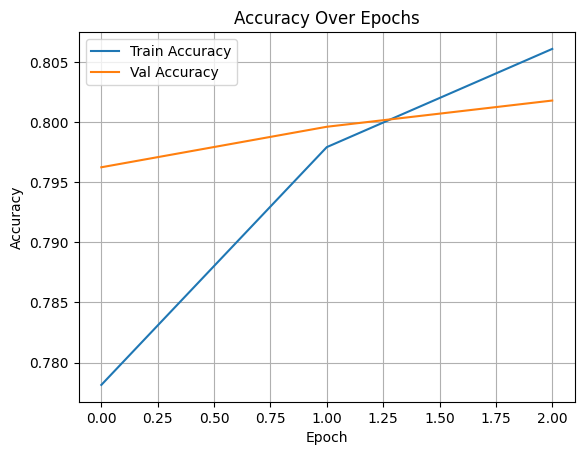

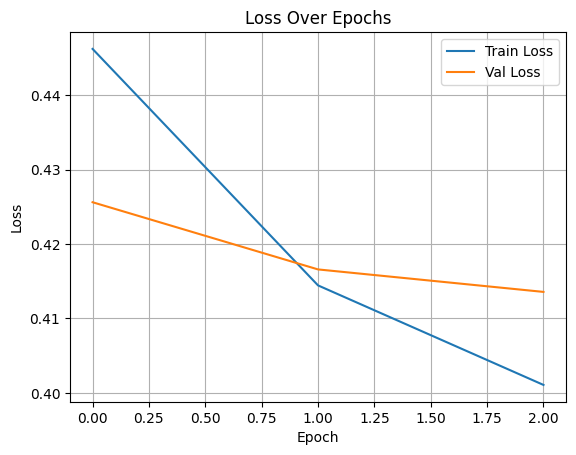

In [ ]:
# Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model_lstm = Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True
    ),
    LSTM(32, return_sequences=False),  # LSTM layer with 32 units
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer with logits
])

model_lstm.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

In [ ]:
history_lstm=model_lstm.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3
)

Epoch 1/3
40500/40500 [==============================] - 1237s 30ms/step - loss: 0.4443 - accuracy: 0.7804 - val_loss: 0.4245 - val_accuracy: 0.7925
Epoch 2/3
40500/40500 [==============================] - 1112s 27ms/step - loss: 0.4119 - accuracy: 0.7997 - val_loss: 0.4079 - val_accuracy: 0.8021
Epoch 3/3
40500/40500 [==============================] - 1004s 25ms/step - loss: 0.3961 - accuracy: 0.8097 - val_loss: 0.4014 - val_accuracy: 0.8117


In [ ]:
start=time.time()
test_loss, test_accuracy = model_lstm.evaluate(test_dataset)
end=time.time()
time_lstm=end-start
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Evaluation Time: {end-start:.2f} seconds")

5000/5000 [==============================] - 40s 8ms/step - loss: 0.4009 - accuracy: 0.8114

Test Loss: 0.4009
Test Accuracy: 0.8114
Evaluation Time: 39.73 seconds


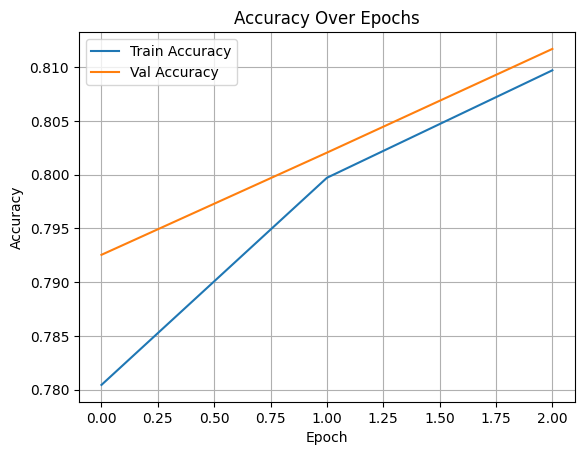

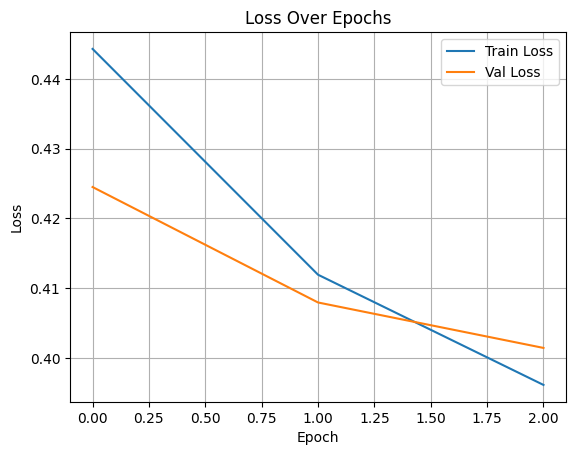

In [ ]:
# Plot Accuracy
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

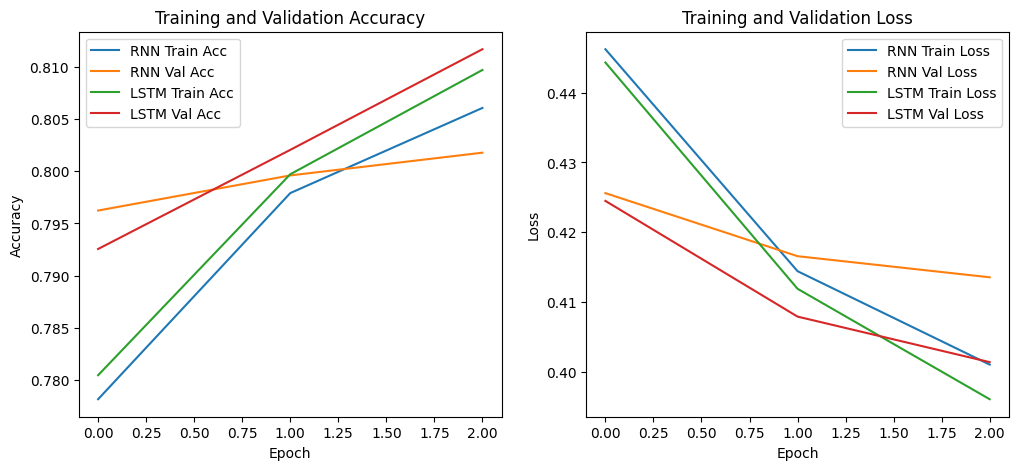

In [ ]:
plt.figure(figsize=(12, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='RNN Train Acc')
plt.plot(history.history['val_accuracy'], label='RNN Val Acc')
plt.plot(history_lstm.history['accuracy'], label='LSTM Train Acc')
plt.plot(history_lstm.history['val_accuracy'], label='LSTM Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='RNN Train Loss')
plt.plot(history.history['val_loss'], label='RNN Val Loss')
plt.plot(history_lstm.history['loss'], label='LSTM Train Loss')
plt.plot(history_lstm.history['val_loss'], label='LSTM Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
results = {
    "Model": ["RNN", "LSTM"],
    "Final Train Accuracy": [history.history['accuracy'][-1], history_lstm.history['accuracy'][-1]],
    "Final Val Accuracy": [history.history['val_accuracy'][-1], history_lstm.history['val_accuracy'][-1]],
    "Final Train Loss": [history.history['loss'][-1], history_lstm.history['loss'][-1]],
    "Final Val Loss": [history.history['val_loss'][-1], history_lstm.history['val_loss'][-1]],
    "Training Time (seconds)": [time_rnn, time_lstm]
}

df_results = pd.DataFrame(results)

# Round values for clarity
df_results = df_results.round({
    "Final Train Accuracy": 3,
    "Final Val Accuracy": 3,
    "Final Train Loss": 3,
    "Final Val Loss": 3,
    "Training Time (seconds)": 2
})

# Style the DataFrame with borders for all cells
styled_table = df_results.style.set_table_styles([
    {'selector': 'th, td', 'props': [('border', '1px solid black'), ('padding', '6px')]}
]).set_properties(**{
    'border-collapse': 'collapse',
    'border': '1px solid black'
})

styled_table


,Model,Final Train Accuracy,Final Val Accuracy,Final Train Loss,Final Val Loss,Training Time (seconds)
0,RNN,0.806000,0.802000,0.401000,0.414000,91.230000
1,LSTM,0.810000,0.812000,0.396000,0.401000,39.730000
